In [3]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim

In [4]:
epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

transform.ToTensor() - this function turns in

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainingset = datasets.MNIST('/data/', train=True, download=True, transform = transform)

Extracting /data/MNIST\raw\train-images-idx3-ubyte.gz to /data/MNIST\raw


Extracting /data/MNIST\raw\train-labels-idx1-ubyte.gz to /data/MNIST\raw



Extracting /data/MNIST\raw\t10k-images-idx3-ubyte.gz to /data/MNIST\raw


Extracting /data/MNIST\raw\t10k-labels-idx1-ubyte.gz to /data/MNIST\raw
Processing...
Done!


In [6]:
import os 
os.getcwd()

'C:\\Users\\Aurelijus\\Documents\\GitHub\\DIT411-Introduction-to-AI'

In [7]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.1307,), (0.3081,))])),batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])),batch_size=batch_size_test, shuffle=True)

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [9]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

<Figure size 640x480 with 6 Axes>

In [11]:
def test_model(model, test_loader):
    total = 0
    nr_correct = 0
    
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total += images.size(0)
        nr_correct += torch.sum(predictions == labels).item()
                
    return nr_correct / total

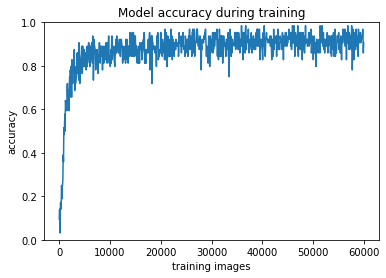

0.9221


In [12]:
model = nn.Sequential(
    nn.Linear(28 * 28, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(1)
)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

total = 0
nr_correct = 0

accuracy = []
for n in range(0, epochs):
    for (batch_index, (images, labels)) in enumerate(train_loader):
        images = images.view(images.shape[0], -1)
        result = model(images)

        optimizer.zero_grad()
        
        loss = criterion(result, labels)
        loss.backward()
        
        optimizer.step()

        _, predictions = torch.max(result, 1)
        total = images.size(0)
        nr_correct = torch.sum(predictions == labels).item()

        accuracy.append(nr_correct / total)

    
fig, ax = plt.subplots()
ax.plot(
    range(0, len(accuracy) * batch_size_train, batch_size_train), 
    accuracy
)

ax.set_ylim((0, 1))
ax.set(
    xlabel='training images', 
    ylabel='accuracy',
    title='Model accuracy during training'
)

plt.show()

print(test_model(model, test_loader))

In [13]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


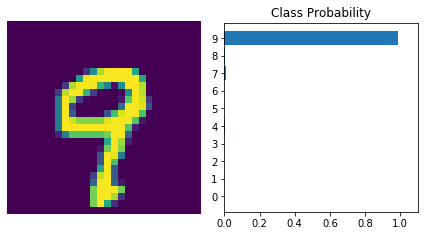

In [29]:
images, labels = next(iter(test_loader))
img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)